# Indonesian Twitter’s Tweets Cyberbullying Detection

# Table of Contents

1. [**Import Package**](#import_package) <br>
    1.1. [Install package](#import_package_install) <br>
    1.2. [General Package](#import_package_general) <br>
    1.3. [Scikit-Learn Package](#import_package_sklearn) <br>
    1.4. [BERT (Pytorch, Transformer, etc) Package](#import_package_bert) <br>
    
    
2. [**Read Dataset**](#read_dataset)<br>


3. [**Preprocessing**](#preprocessing) <br>


4. [**Exploratory Data Analysis**](#eda) <br>
    4.1. [Shape of Data](#eda_shape) <br>
    4.2. [Bully Tweet Proportion](#eda_bullyprop) <br>
    4.3. [Wordcloud](#eda_wordcloud) <br>
    4.4. [Char Count](#eda_charcount) <br>
    4.5. [Word Count](#eda_wordcount) <br>


5. [**Model Training**](#training) <br>
    5.1. [Random Forest](#training_rf) <br>
    5.1.1. [*Full Preprocess*](#training_rf_full) <br>
    5.1.2. [*Without Stemming*](#training_rf_nostem) <br>
    5.1.3. [*Without Stopword and Stemming*](#training_rf_nostemstop) <br>
    
    5.2. [Logistic regression](#training_lr) <br>
    5.2.1. [*Full Preprocess*](#training_lr_full) <br>
    5.2.2. [*Without Stemming*](#training_lr_nostem) <br>
    5.2.3. [*Without Stopword and Stemming*](#training_lr_nostemstop) <br>
    
    5.3. [BERT (indobenchmark)](#training_bert) <br>
    5.3.1. [*Check GPU*](#training_bert_gpucek) <br>
    5.3.2. [*Setting Cuda*](#training_bert_cuda) <br>
    5.3.3. [*Load Bert Tokenizer*](#training_bert_tokenizer) <br>
    5.3.4. [*Tokenization*](#training_bert_tokenize) <br>
    5.3.5. [*Create Tensor Dataset*](#training_bert_tensordata) <br>
    5.3.6. [*Create Model and Optimizer*](#training_bert_model) <br>
    5.3.7. [*Training*](#training_bert_train) <br>
    5.3.8. [*Testing and Evaluation*](#training_bert_testing) <br>
    
    5.4. [Save Best Model](#training_save) <br>
   
   
6. [**Model Predict**](#predict)

# Import Package <a class='anchor' id='import_package'></a>

## Install Package <a class='anchor' id='import_package_install'></a>

In [1]:
!pip install pysastrawi

#for bert
!pip install gputil --q
!pip install psutil --q
!pip install humanize --q
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 32.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 19.3 MB/s 
     |████████████████████████████████| 596 kB 58.9 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 55.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## General Package <a class='anchor' id='import_package_general'></a>

In [2]:
from google.colab import drive

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
sns.set_style("whitegrid")

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pickle

import time

import warnings
warnings.filterwarnings("ignore")

## Scikit-Learn Package <a class='anchor' id='import_sklearn'></a>

In [3]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

## BERT (Pytorch, Transformer, etc) Package <a class='anchor' id='import_package_bert'></a>

In [4]:
import psutil
import humanize
import os
import GPUtil as GPU

import torch

from transformers import BertTokenizer

import statistics

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# Read Dataset <a class='anchor' id='read_dataset'></a>

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
data_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Latihan/Indonesia Cyber Bully Tweet/Data/train.csv')
data_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Latihan/Indonesia Cyber Bully Tweet/Data/test.csv')

In [7]:
data_train.head(10)

,bully,tweet,individual,group,gender,physical,race,religion
0,no,USER terimakasih Ustadz sudah bersuara tentang...,0,0,0,0,0,0
1,no,USER USER Maaf sebenarnya twiter pertama kali ...,0,0,0,0,0,0
2,yes,USER Anjing tai goblok idiot bangsat monyet ba...,1,0,1,1,0,0
3,no,"Hadiri Lokakarya Kebudayaan Daerah, Bupati Rup...",0,0,0,0,0,0
4,yes,USER USER USER yg kaya gini layak di tangkap.,1,0,0,0,0,0
5,yes,ini namanya memancing konflik horizontal kalo ...,1,0,0,0,0,0
6,no,"USER Wonu oppa kenapa matanya sipit banget? '^'""",0,0,0,0,0,0
7,yes,Smartfren jaringan nya kok brengsek ya ...',0,1,0,0,0,0
8,yes,"USER USER Pret.. kampret , Tak dukung 2019 gan...",1,0,0,0,0,0
9,yes,USER Ahelah sombong bener punuk onta',1,0,0,0,0,0


In [8]:
data_test.head(10)

,id,bully,tweet
0,o66172,NaN,"41. Kadang aku berfikir, kenapa aku tetap perc..."
1,s9818,NaN,"Setidaknya gw punya jari tengah buat lu, sebel..."
2,n96529,NaN,Belakangan ini kok fikiran ampas banget ya'
3,c86722,NaN,Dari habis sahur sampe jam 10. Sibayik udah ne...
4,j28486,NaN,USER USER Presiden RI Jokowi luarBiasa kerja n...
5,r43469,NaN,GAPERNAH MENDALAMI AL-QURAN YA BANG??? PANTESA...
6,v34095,NaN,"Sangat terlihat beda sekali Kewibawaannya ,; y..."
7,k34813,NaN,Anjir baru kali ini lihat orang bego mau debat...
8,e30417,NaN,USER USER USER USER Kata Sembahyang mengadopsi...
9,t91452,NaN,USER Awaasss... Jgn sampe beritanya sampe ke a...


In [9]:
data_train.shape

(10535, 8)

# Preprocessing <a class='anchor' id='preprocessing'></a>

In [10]:
#IMPORT STOPWORD
with open("/content/gdrive/MyDrive/Colab Notebooks/Latihan/Indonesia Cyber Bully Tweet/Data/stopword_nonltk.pkl","rb") as f:
    stopword_ls = pickle.load(f)

# IMPORT MEANINGLESS WORD
meaningless_ls = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Latihan/Indonesia Cyber Bully Tweet/Data/meaningless.csv",header=None)
meaningless_ls = meaningless_ls[0].values.tolist()

In [11]:
#IMPORT NORMALIZATION DICTIONARY
normalization_ls = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Latihan/Indonesia Cyber Bully Tweet/Data/kamus_normalisasi.csv",header=None,names=["non-standard word","standard word"])

In [12]:
normalization_ls.head(10)

,non-standard word,standard word
0,27-Jun,dua puluh tujuh juni
1,01curang,01 curang
2,01thechampion,01 the champion
3,02wintheelection,02 win the election
4,½ramayana,ramayana
5,10000hours,10000 hours
6,10harilagigantipresiden,10 hari lagi ganti presiden
7,10harilagilebaranakalsehat,10 hari lagi lebaran akal sehat
8,10harimenujumenang,10 hari menuju menang
9,10jt,sepuluh juta


In [13]:
def preprocess(series_text,rm_stopwords = False, stemming = False, normalization = False, rm_meaningless = False, stopwords_ls = None, normalization_ls = None, meaningless_ls = None):
    # TEXT CLEANING
    series_text = pd.Series(series_text)
    series_text = series_text.str.lower()
    series_text = series_text.str.replace("\n", " ")
    series_text = series_text.str.replace("\r", " ")
    series_text = series_text.str.replace("&amp", " ")
    series_text = series_text.str.replace("&gt", " ")
    series_text = series_text.str.replace("&lt", " ")
    series_text = series_text.str.replace(r'''(?i)\b((?:https|http?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ")
    series_text = series_text.str.replace('"', '')
    series_text = series_text.str.replace(r"\s+"," ")
    series_text = series_text.str.replace("[^a-z0-9]"," ")
    series_text = series_text.str.strip()
    
    # WORD NORMALIZATION
    if normalization == True:
        nonstdword = normalization_ls['non-standard word'].values.tolist()
        stdword = normalization_ls['standard word'].values.tolist()
        
        def normalize_text(text,stdword_,nonstdword_):
            text = text.split(" ")
            for i in range(len(text)):
                if text[i] in nonstdword:
                    index = nonstdword_.index(text[i])
                    text[i] = stdword_[index]
            return ' '.join(text)
        
        series_text = series_text.map(lambda txt : normalize_text(txt,stdword,nonstdword))
    
    # series_text = series_text.str.replace("[^a-z]"," ")
    
    # MEANINGLESS WORD REMOVAL
    if rm_meaningless == True:
        for ml in meaningless_ls:
            regex_meaningless = r"\b" + ml + r"\b"
            series_text = series_text.str.replace(regex_meaningless,'')
    
    # STOPWORD REMOVAL
    if rm_stopwords == True:
        for sw in stopwords_ls:
            regex_stopword = r"\b" + sw + r"\b"
            series_text = series_text.str.replace(regex_stopword,'')
            
    # STEMMING
    if stemming == True:
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        
        series_text = series_text.map(lambda txt : stemmer.stem(txt))
    
    return series_text

In [14]:
# FULL PREPROCESS
data_train['prep_tweet_full'] = preprocess(data_train['tweet'],rm_stopwords = True, stemming = True, 
                                      normalization = True, rm_meaningless = True, stopwords_ls = stopword_ls, 
                                      normalization_ls = normalization_ls, meaningless_ls = meaningless_ls)

data_test['prep_tweet_full'] = preprocess(data_test['tweet'],rm_stopwords = True, stemming = True, 
                                      normalization = True, rm_meaningless = True, stopwords_ls = stopword_ls, 
                                      normalization_ls = normalization_ls, meaningless_ls = meaningless_ls)

# NO STEMMING
data_train['prep_tweet_nostem'] = preprocess(data_train['tweet'],rm_stopwords = True, stemming = False, 
                                      normalization = True, rm_meaningless = True, stopwords_ls = stopword_ls, 
                                      normalization_ls = normalization_ls, meaningless_ls = meaningless_ls)

data_test['prep_tweet_nostem'] = preprocess(data_test['tweet'],rm_stopwords = True, stemming = False, 
                                      normalization = True, rm_meaningless = True, stopwords_ls = stopword_ls, 
                                      normalization_ls = normalization_ls, meaningless_ls = meaningless_ls)

# NO STOPWORD AND STEMMING
data_train['prep_tweet_nostemstop'] = preprocess(data_train['tweet'],rm_stopwords = False, stemming = False, 
                                      normalization = True, rm_meaningless = False, stopwords_ls = stopword_ls, 
                                      normalization_ls = normalization_ls, meaningless_ls = meaningless_ls)

data_test['prep_tweet_nostemstop'] = preprocess(data_test['tweet'],rm_stopwords = False, stemming = False, 
                                      normalization = True, rm_meaningless = False, stopwords_ls = stopword_ls, 
                                      normalization_ls = normalization_ls, meaningless_ls = meaningless_ls)

In [ ]:
data_train['prep_tweet_nostem'].head(10)

0     terima kasih ustaz  bersuara  radikal radikal...
1                    maaf  twitter  kali    orang bego
2     anjing tai goblok idiot bangsat monyet babi f...
3    hadiri lokakarya kebudayaan daerah  bupati rup...
4                                 kaya  layak  tangkap
5     namanya memancing konflik horizontal  polisi ...
6                      wonu oppa  matanya sipit banget
7                      smartfren jaringan   berengsek 
8      pret   kampret   tidak dukung 2019 ganti pre...
9                                  sombong  punuk unta
Name: prep_tweet_nostem, dtype: object

In [ ]:
data_train[data_train['prep_tweet_nostem'].str.contains('1')]

,bully,tweet,individual,group,gender,physical,race,religion,prep_tweet_full,prep_tweet_nostem,prep_tweet_nostemstop


In [ ]:
data_train.loc[6973]['tweet']

'DALAM rapat terbatas tentang perkembangan persiapan Asian Games XVIII di Istana Kepresidenan Bogor, Rabu 18 April 2018, Presiden Joko Widodo mengingatkan pentingnya...'

In [ ]:
data_train.loc[6973]['prep_tweet_full']

'rapat batas kembang siap asi games istana presiden bogor rabu april presiden joko widodo'

In [ ]:
data_train.loc[6973]['prep_tweet_nostem']

' rapat terbatas  perkembangan persiapan asian games     istana kepresidenan bogor  rabu    april       presiden joko widodo  '

In [ ]:
data_train.loc[6973]['prep_tweet_nostemstop']

'dalam rapat terbatas tentang perkembangan persiapan asian games    di istana kepresidenan bogor  rabu    april       presiden joko widodo mengingatkan pentingnya'

# Exploratory Data Analysis <a class='anchor' id='eda'></a>

# Shape of Data <a class='anchor' id='eda_shape'></a>

In [ ]:
data_train.shape

(10535, 11)

In [ ]:
data_train[data_train['bully'] == 'yes'].head(5)

,bully,tweet,individual,group,gender,physical,race,religion,prep_tweet_full,prep_tweet_nostem,prep_tweet_nostemstop
2,yes,USER Anjing tai goblok idiot bangsat monyet ba...,1,0,1,1,0,0,anjing tai goblok idiot bangsat monyet babi fu...,anjing tai goblok idiot bangsat monyet babi f...,anjing tai goblok idiot bangsat monyet babi f...
4,yes,USER USER USER yg kaya gini layak di tangkap.,1,0,0,0,0,0,kaya layak tangkap,kaya layak tangkap,kaya begini layak di tangkap
5,yes,ini namanya memancing konflik horizontal kalo ...,1,0,0,0,0,0,nama pancing konflik horizontal polisi biar le...,namanya memancing konflik horizontal polisi ...,ini namanya memancing konflik horizontal kalau...
7,yes,Smartfren jaringan nya kok brengsek ya ...',0,1,0,0,0,0,smartfren jaring berengsek,smartfren jaringan berengsek,smartfren jaringan berengsek
8,yes,"USER USER Pret.. kampret , Tak dukung 2019 gan...",1,0,0,0,0,0,pret kampret tidak dukung ganti presiden presi...,pret kampret tidak dukung ganti pre...,pret kampret tidak dukung ganti pre...


In [ ]:
data_train[data_train['bully'] == 'no'].head(5)

,bully,tweet,individual,group,gender,physical,race,religion,prep_tweet_full,prep_tweet_nostem,prep_tweet_nostemstop
0,no,USER terimakasih Ustadz sudah bersuara tentang...,0,0,0,0,0,0,terima kasih ustaz suara radikal radikal pikir...,terima kasih ustaz bersuara radikal radikal...,terima kasih ustaz sudah bersuara tentang rad...
1,no,USER USER Maaf sebenarnya twiter pertama kali ...,0,0,0,0,0,0,maaf twitter kali orang bego,maaf twitter kali orang bego,maaf sebenarnya twitter pertama kali dibuat ...
3,no,"Hadiri Lokakarya Kebudayaan Daerah, Bupati Rup...",0,0,0,0,0,0,hadir lokakarya budaya daerah bupati rupinus a...,hadiri lokakarya kebudayaan daerah bupati rup...,hadiri lokakarya kebudayaan daerah bupati rup...
6,no,"USER Wonu oppa kenapa matanya sipit banget? '^'""",0,0,0,0,0,0,wonu oppa mata sipit banget,wonu oppa matanya sipit banget,wonu oppa kenapa matanya sipit banget
10,no,USER jancuk kw zonk!!!!',0,0,0,0,0,0,jancuk kw apes,jancuk kw apes,jancuk kw apes


In [ ]:
data_test.shape

(2634, 6)

## Bully Tweet Proportion <a class='anchor' id='eda_bullyprop'></a>

In [ ]:
(temp['count_bully'].values/sum(temp['count_bully'])).round()

array([1., 0.])

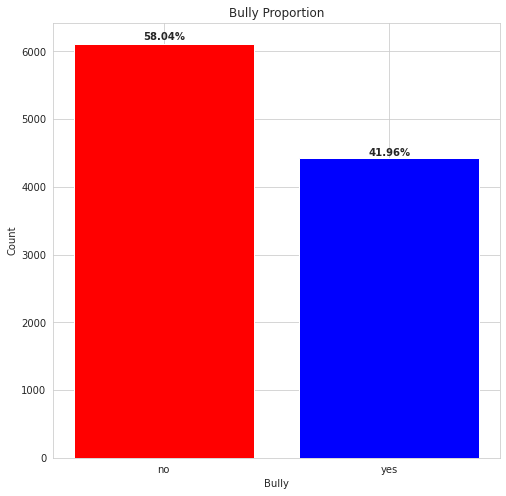

In [ ]:
# data_train.groupby('bully').agg(count_bully = ('bully','count')).plot.bar(color=['Blue'],legend=False)

temp = data_train.groupby('bully').agg(count_bully = ('bully','count')).reset_index()

plt.figure(figsize=(8,8))
colors_list = ['red','blue']
graph = plt.bar(temp['bully'],temp['count_bully'], color = colors_list)
plt.title("Bully Proportion")
plt.ylabel('Count')
plt.xlabel('Bully')

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x,y = p.get_xy()
    plt.text(x+width/2,
            y+height*1.01,
            str(((temp['count_bully'].values/sum(temp['count_bully']))*100).round(2)[i])+'%',
            ha='center',
            weight='bold')
    i+=1

plt.show()

In [ ]:
data_train.groupby('bully').agg(count_bully = ('bully','count')).reset_index()

,bully,count_bully
0,no,6114
1,yes,4421


## Bully Tweet Category Proportion <a class='anchor' id='eda_catprop'></a>

In [ ]:
label_size = []

for i in data_train[data_train['bully'] == 'yes'].columns[2:8]:
    label_size.append(len(data_train[(data_train['bully'] == 'yes')&(data_train[i]==1)]))

In [ ]:
temp = pd.DataFrame({
    'label' : data_train.columns[2:8],
    'count_bully' : label_size,
}).sort_values('count_bully',ascending=False).reset_index(drop=True)

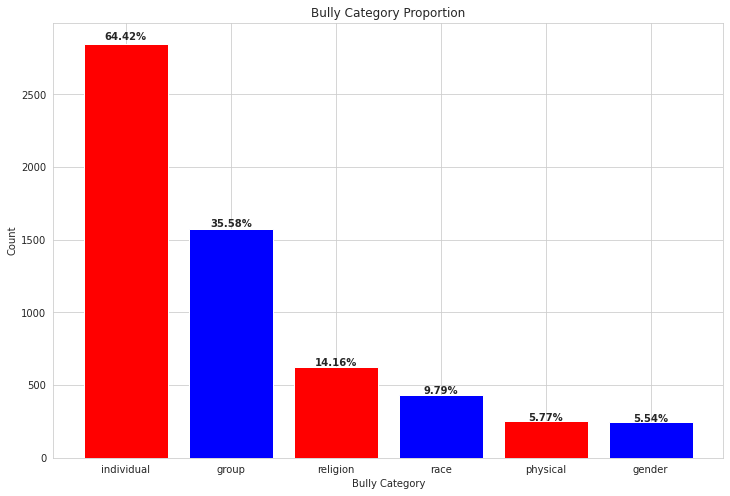

In [ ]:
plt.figure(figsize=(12,8))
colors_list = ['red','blue']
graph = plt.bar(temp['label'],temp['count_bully'], color = colors_list)
plt.title("Bully Category Proportion")
plt.ylabel('Count')
plt.xlabel('Bully Category')

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x,y = p.get_xy()
    plt.text(x+width/2,
            y+height*1.01,
            str(((temp['count_bully'].values/data_train[data_train['bully'] == 'yes'].shape[0])*100).round(2)[i])+'%',
            ha='center',
            weight='bold')
    i+=1

plt.show()

In [ ]:
temp

,label,count_bully
0,individual,2848
1,group,1573
2,religion,626
3,race,433
4,physical,255
5,gender,245


## Wordcloud <a class='anchor' id='eda_wordcloud'></a>

In [ ]:
def word_cloud(data, filenames):
    def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return("hsl(0,100%, 1%)")
    columns  = list(data)
    
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

def show_wordcloud(data,title):
    wordcloud = WordCloud(background_color="white", width=1000, height=500, max_words=100).generate_from_frequencies(data)
    # set the word color to black
    wordcloud.recolor(color_func = black_color_func)
    # set the figsize
    plt.figure(figsize=[10,5])
    # plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")
    # remove plot axes
    plt.axis("off")
    plt.title(title)
    # save the image
    # plt.savefig('biden_wc.png')

In [ ]:
course_grouped = data_train.groupby('bully')['prep_tweet_full'].apply(lambda x : " ".join(x)).reset_index()
grouped_tfidf = TfidfVectorizer()
grouped_tfidf.fit(course_grouped['prep_tweet_full'])
course_grouped_tfidf = pd.DataFrame(grouped_tfidf.transform(course_grouped['prep_tweet_full']).toarray(),
                                    columns = grouped_tfidf.get_feature_names())
course_grouped_tfidf['bully'] = course_grouped['bully']
course_grouped_tfidf = course_grouped_tfidf.set_index("bully").transpose()

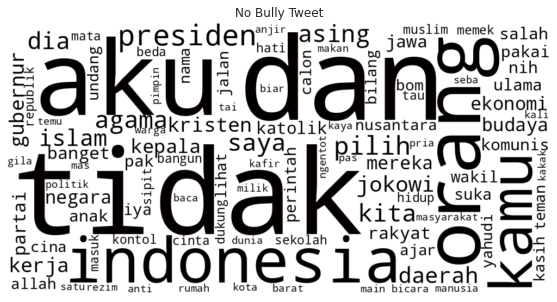

In [ ]:
show_wordcloud(course_grouped_tfidf['no'],'No Bully Tweet')

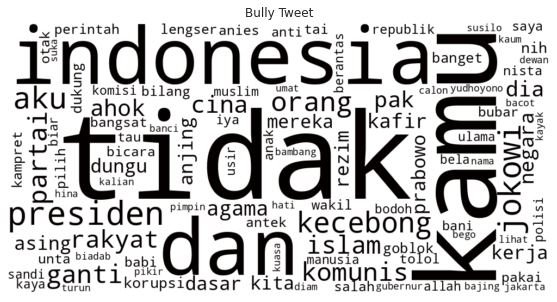

In [ ]:
show_wordcloud(course_grouped_tfidf['yes'],'Bully Tweet')

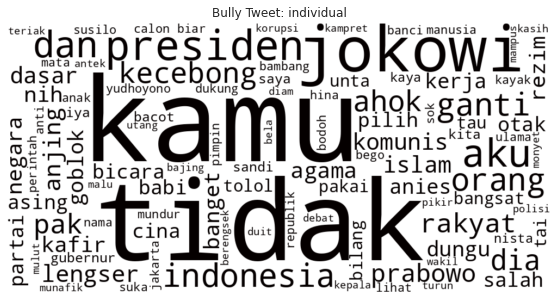

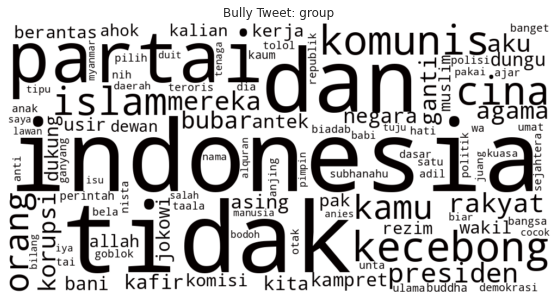

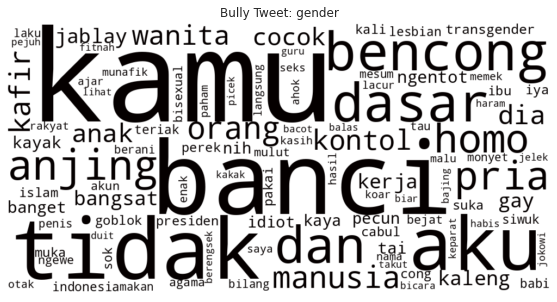

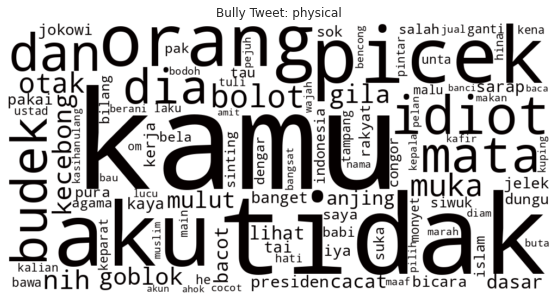

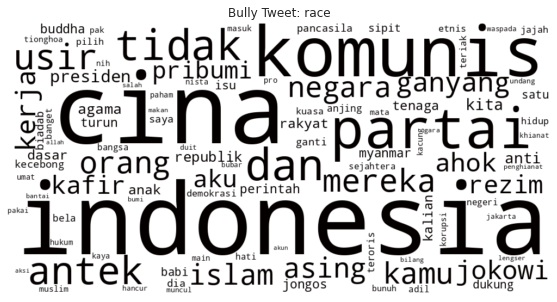

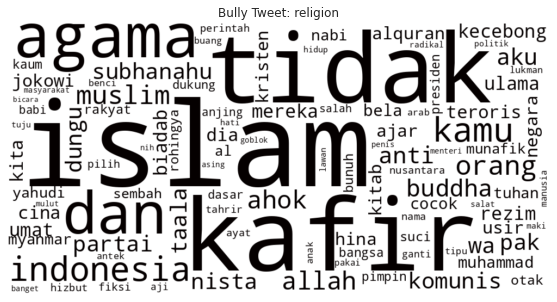

In [ ]:
for i in data_train.columns[2:8]:
    course_grouped = data_train[data_train[i] == 1].groupby('bully')['prep_tweet_full'].apply(lambda x : " ".join(x)).reset_index()
    grouped_tfidf = TfidfVectorizer()
    grouped_tfidf.fit(course_grouped['prep_tweet_full'])
    course_grouped_tfidf = pd.DataFrame(grouped_tfidf.transform(course_grouped['prep_tweet_full']).toarray(),
                                        columns = grouped_tfidf.get_feature_names())
    course_grouped_tfidf['bully'] = course_grouped['bully']
    course_grouped_tfidf = course_grouped_tfidf.set_index("bully").transpose()
    
    title = 'Bully Tweet: '+str(i)
    show_wordcloud(course_grouped_tfidf['yes'],title)

## Char Count <a class='anchor' id='eda_charcount'></a>

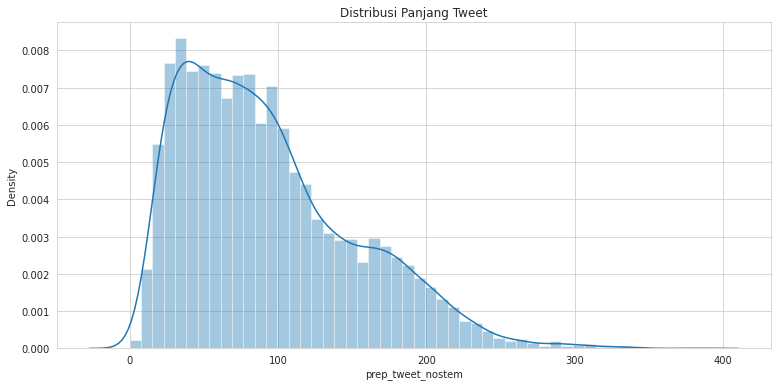

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(data_train['prep_tweet_nostem'].str.len()).set_title('Distribusi Panjang Tweet');

## Word Count <a class='anchor' id='eda_wordcount'></a>

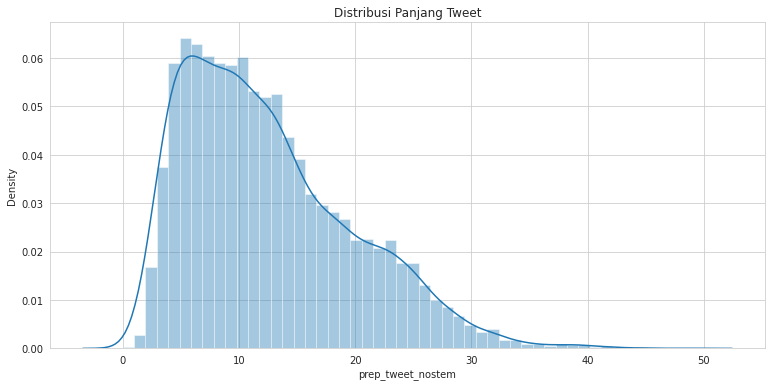

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(data_train['prep_tweet_nostem'].apply(lambda txt : len(str(txt).split()))).set_title('Distribusi Panjang Tweet');

# Model Training <a class='anchor' id='training'></a>

In [15]:
X = data_train[['prep_tweet_full','prep_tweet_nostem','prep_tweet_nostemstop']]
y = data_train['bully']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [16]:
y_train_enc = y_train.copy()
y_train_enc[y_train_enc == 'yes'] = 1
y_train_enc[y_train_enc == 'no'] = 0
y_train_enc = y_train_enc.astype(int)

y_test_enc = y_test.copy()
y_test_enc[y_test_enc == 'yes'] = 1
y_test_enc[y_test_enc == 'no'] = 0
y_test_enc = y_test_enc.astype(int)

## Random Forest <a class='anchor' id='training_rf'></a>

In [ ]:
model_rf = RandomForestClassifier(n_jobs=-1)
pipeline_rf = make_pipeline(TfidfVectorizer(ngram_range = (1,1)),model_rf)

In [ ]:
param_grid_rf = {'randomforestclassifier__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
               'randomforestclassifier__min_samples_split': [2, 5, 10],
               'randomforestclassifier__min_samples_leaf': [1, 2, 4],
               'randomforestclassifier__bootstrap': [True, False]
                     }

### Full Preprocess <a class='anchor' id='training_rf_full'></a>

In [ ]:
grid_search_rf_full = GridSearchCV(estimator=pipeline_rf,
                                     param_grid=param_grid_rf,
                                     cv=3,
                                     n_jobs = -1)

grid_search_rf_full.fit(X_train['prep_tweet_full'],y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__bootstrap': [True, False],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 4],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [100, 200, 300,
                                                                  400, 500, 600,
                                                                  700, 800, 900,
                                                                  1000]})

In [ ]:
grid_search_rf_full.best_score_

0.8358432384249787

In [ ]:
grid_search_rf_full.best_params_

{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 800}

In [ ]:
grid_search_rf_full.best_estimator_.score(X_test['prep_tweet_full'],y_test)

0.840167046317388

### Without Stemming <a class='anchor' id='training_rf_nostem'></a>

In [ ]:
grid_search_rf_nostem = GridSearchCV(estimator=pipeline_rf,
                                     param_grid=param_grid_rf,
                                     cv=3,
                                     n_jobs = -1)

grid_search_rf_nostem.fit(X_train['prep_tweet_nostem'],y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__bootstrap': [True, False],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 4],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [100, 200, 300,
                                                                  400, 500, 600,
                                                                  700, 800, 900,
                                                                  1000]})

In [ ]:
grid_search_rf_nostem.best_score_

0.8354626264408967

In [ ]:
grid_search_rf_nostem.best_params_

{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 200}

In [ ]:
grid_search_rf_nostem.best_estimator_.score(X_test['prep_tweet_nostem'],y_test)

0.8439635535307517

### Without Stopword and Stemming <a class='anchor' id='training_rf_nostemstop'></a>

In [ ]:
grid_search_rf_nostemstop = GridSearchCV(estimator=pipeline_rf,
                                     param_grid=param_grid_rf,
                                     cv=3,
                                     n_jobs = -1)

grid_search_rf_nostemstop.fit(X_train['prep_tweet_nostemstop'],y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__bootstrap': [True, False],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 4],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [100, 200, 300,
                                                                  400, 500, 600,
                                                                  700, 800, 900,
                                                                  1000]})

In [ ]:
grid_search_rf_nostemstop.best_score_

0.8352095259600057

In [ ]:
grid_search_rf_nostemstop.best_params_

{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 900}

In [ ]:
grid_search_rf_nostemstop.best_estimator_.score(X_test['prep_tweet_nostemstop'],y_test)

0.853454821564161

## Logistic Regression <a class='anchor' id='training_lr'></a>

In [ ]:
model_lr = LogisticRegression(solver = 'lbfgs',max_iter=1000,n_jobs=-1)
pipeline_lr = make_pipeline(TfidfVectorizer(ngram_range = (1,1)),model_lr)

In [ ]:
param_grid_lr = {'logisticregression__solver' : ['saga','lbfgs'],
                 'logisticregression__penalty' : ['l1', 'l2'],
                 'logisticregression__C' : np.logspace(-4,4,20)
                }


### Full Preprocess <a class='anchor' id='training_lr_full'></a>

In [ ]:
grid_search_lr_full = GridSearchCV(estimator=pipeline_lr,
                                   param_grid=param_grid_lr,
                                   cv=3,
                                   n_jobs = -1)

grid_search_lr_full.fit(X_train['prep_tweet_full'],y_train_enc)

/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-pack

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['saga', 'lbfgs']})

In [ ]:
grid_search_lr_full.best_params_

{'logisticregression__C': 4.281332398719396,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}

In [ ]:
grid_search_lr_full.best_score_

0.8310335122147178

In [ ]:
grid_search_lr_full.best_estimator_.score(X_test['prep_tweet_nostemstop'],y_test_enc)

0.819665907365224

### Without Stemming <a class='anchor' id='training_lr_nostem'></a>

In [ ]:
grid_search_lr_nostem = GridSearchCV(estimator=pipeline_lr,
                                     param_grid=param_grid_lr,
                                     cv=3,
                                     n_jobs = -1)

grid_search_lr_nostem.fit(X_train['prep_tweet_nostem'],y_train_enc)

/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-pack

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['saga', 'lbfgs']})

In [ ]:
grid_search_lr_nostem.best_params_

{'logisticregression__C': 4.281332398719396,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs'}

In [ ]:
grid_search_lr_nostem.best_score_

0.8286279041309593

In [ ]:
grid_search_lr_nostem = grid_search_lr

In [ ]:
grid_search_lr_nostem.best_estimator_.score(X_test['prep_tweet_nostemstop'],y_test_enc)

0.8432042520880789

### Without Stopword and Stemming <a class='anchor' id='training_lr_nostemstop'></a>

In [ ]:
grid_search_lr_nostemstop = GridSearchCV(estimator=pipeline_lr,
                                         param_grid=param_grid_lr,
                                         cv=3,
                                         n_jobs = -1)

grid_search_lr_nostemstop.fit(X_train['prep_tweet_nostemstop'],y_train_enc)

/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jupyter-admin/.local/lib/python3.9/site-pack

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['saga', 'lbfgs']})

In [ ]:
grid_search_lr_nostemstop.best_params_

{'logisticregression__C': 4.281332398719396,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'saga'}

In [ ]:
grid_search_lr_nostemstop.best_score_

0.8368554480959932

In [ ]:
grid_search_lr_nostemstop.best_estimator_.score(X_test['prep_tweet_nostemstop'],y_test_enc)

0.8496583143507973

## BERT (indobenchmark) <a class='anchor' id='training_bert'></a>

### Check GPU <a class='anchor' id='training_bert_gpucek'></a>

In [ ]:
torch.cuda.empty_cache()

In [17]:
GPUs = GPU.getGPUs()

# XXX: cek gpu
print("jumlah gpu : ", len(GPUs))

if len(GPUs)>0:
    gpu = GPUs[0]
    def printm():
     process = psutil.Process(os.getpid())
     print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
     print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm()

jumlah gpu :  1
Gen RAM Free: 11.8 GB  | Proc size: 875.5 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


### Setting Cuda <a class='anchor' id='training_bert_cuda'></a>

In [18]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Load Bert Tokenizer <a class='anchor' id='training_bert_tokenizer'></a>

In [19]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1", do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

### Tokenization <a class='anchor' id='training_bert_tokenize'></a>

In [20]:
sentences = X_train['prep_tweet_nostemstop'].values
labels = y_train_enc.astype(int).values

In [21]:
test_sentences = X_test['prep_tweet_nostemstop'].values

In [22]:
sent_length = []

# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    token_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(token_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))

Average length =  22.681938995063916
Median length =  20


In [23]:
# Tokenize all of the sentences and map the tokens to their word IDs.
token_ids  = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 60,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    token_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
token_ids  = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
# labels = torch.nn.functional.one_hot(labels.to(torch.int64))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [24]:
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', token_ids[0])
print('Attention Masks:', attention_masks[0])

Original:  user user user user ya goblok   untung aku kecebong happy bukan yang dungu versi gerung gerung
Token IDs: tensor([    2,  6273,  6273,  6273,  6273,   286, 20298,  6437,  5133,   304,
        25843,  8783, 30365, 10790,   531,    34, 10079,  6833,  2614,  1112,
           76,  1112,    76,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Create Tensor Dataset <a class='anchor' id='training_bert_tensordata'></a>

In [26]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(token_ids, attention_masks, labels)

# Create a 80-20 train-validation split.
# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,110 training samples
  791 validation samples


In [44]:
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Create Model and Optimizer <a class='anchor' id='training_bert_model'></a>

In [65]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", 
    num_labels = 2, 
    output_attentions = False, # return attentions weights
    output_hidden_states = False, # returns all hidden-states
)

if len(GPUs)>0:
  # Tell pytorch to run this model on the GPU.
  model.cuda()
else:
  # Tell pytorch to run this model on the CPU.
  model.cpu()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 1e-5, 
                  eps = 1e-8
                )

### Training <a class='anchor' id='training_bert_train'></a>

In [67]:
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
print('Jumlah batch :', len(train_dataloader))
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 223


In [68]:
def acc_score(y_pred,y_test):
    acc_count = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc_count

In [69]:
# def acc(y_pred,y_test):
#     acc_count = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
#     return acc_count

EPOCHS = epochs

loss_values = []
y_true_val=[]
y_pred_val = []

total_step = len(train_dataloader)

for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (token_ids, attention_masks, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        b_input_ids = token_ids.to(device)
        b_input_mask = attention_masks.to(device)
        labels = labels.to(device)

        loss, prediction = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=labels).values()

#         print(batch_idx)
#         print(labels)
        acc = acc_score(prediction, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc  += acc.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    train_acc  = total_train_acc/len(train_dataloader)
    train_loss = total_train_loss/len(train_dataloader)
    model.eval()
    torch.set_grad_enabled(False)

    total_val_acc  = 0
    total_val_loss = 0
    with torch.no_grad():
        for batch_idx, (token_ids, attention_masks, labels) in enumerate(validation_dataloader):
            optimizer.zero_grad()

            b_input_ids = token_ids.to(device)
            b_input_mask = attention_masks.to(device)
            labels = labels.to(device)

            loss, prediction = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask, 
                                  labels=labels).values()
            
            acc = acc_score(prediction, labels)

            logits = prediction
            logits = logits.detach().cpu().numpy()
            b_labels = labels.to('cpu').numpy()

            y_pred_val.append(logits)
            y_true_val.append(b_labels)

            total_val_loss += loss.item()
            total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(validation_dataloader)
    val_loss = total_val_loss/len(validation_dataloader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch 1: train_loss: 0.4131 train_acc: 0.8115 | val_loss: 0.2887 val_acc: 0.8828
00:01:22.68
Epoch 2: train_loss: 0.2521 train_acc: 0.8984 | val_loss: 0.2993 val_acc: 0.8685
00:01:22.19
Epoch 3: train_loss: 0.1523 train_acc: 0.9449 | val_loss: 0.3176 val_acc: 0.8833
00:01:21.98


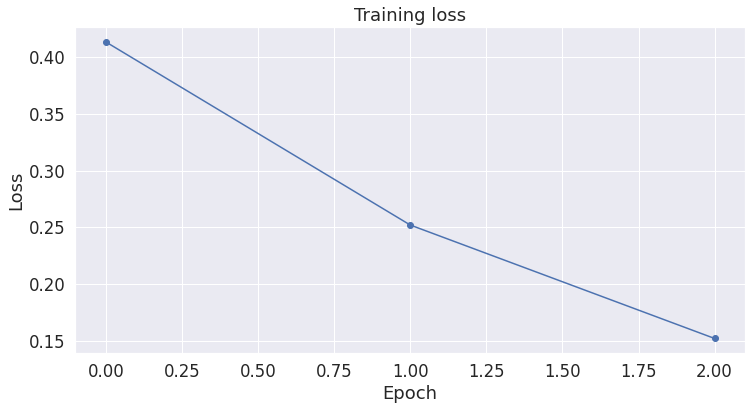

In [70]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### Testing and Evaluation <a class='anchor' id='training_bert_testing'></a>

In [71]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
token_ids  = []
attention_masks = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 60,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        # padding = 'max_length',
                   )
    
    # Add the encoded sentence to the list.    
    token_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
token_ids = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Set the batch size.  
batch_size = 1

# Create the DataLoader.
prediction_data = TensorDataset(token_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [72]:
print('Jumlah batch :', len(prediction_dataloader))

Jumlah batch : 2634


In [73]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(token_ids)))

# Put model in evaluation mode
model.eval()
torch.set_grad_enabled(False)

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    
    # Store predictions and true labels
    predictions.append(logits)

print('    DONE.')

Predicting labels for 2,634 test sentences...
    DONE.


In [74]:
predictions = np.concatenate(predictions, axis=0)
predictions = predictions.argmax(axis=1)

In [75]:
accuracy_score(predictions,y_test_enc.values)

0.8747152619589977

## Save Best Model <a class='anchor' id='training_save'></a>

In [76]:
# with open('../Model/random_forest.pkl','wb') as f:
#     pickle.dump(grid_search_rf_nostemstop.best_estimator_,f)

pickle.dump(model,open('/content/gdrive/MyDrive/Colab Notebooks/Latihan/Indonesia Cyber Bully Tweet/Model/bert_3.pkl','wb'))

# Model Predict <a class='anchor' id='predict'></a>

use the best model to predict data test

In [77]:
unseen_sentences = data_test['prep_tweet_nostemstop'].values

In [78]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
token_ids  = []
attention_masks = []

# For every sentence...
for sent in unseen_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 60,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    token_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
token_ids = torch.cat(token_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Set the batch size.  
batch_size = 1

# Create the DataLoader.
prediction_data = TensorDataset(token_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [79]:
print('Jumlah batch :', len(prediction_dataloader))

Jumlah batch : 2634


In [80]:
# Prediction on test set

print('Predicting labels for {:,} unseen sentences...'.format(len(token_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)
        
        logits = outputs[0]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        
        # Store predictions and true labels
        predictions.append(logits)

print('    DONE.')

Predicting labels for 2,634 unseen sentences...
    DONE.


In [81]:
predictions = np.concatenate(predictions, axis=0)
predictions = predictions.argmax(axis=1)

In [82]:
predictions

array([0, 1, 0, ..., 1, 1, 0])

In [83]:
data_test['bully'] = predictions
data_test['bully'] = data_test['bully'].astype(str)
data_test.loc[data_test['bully'] == '1', 'bully'] = 'yes'
data_test.loc[data_test['bully'] == '0', 'bully'] = 'no'

In [84]:
data_test[['id','bully']].to_csv('/content/gdrive/MyDrive/Colab Notebooks/Latihan/Indonesia Cyber Bully Tweet/results_bert.csv',index=False)

In [85]:
data_test.head(5)

,id,bully,tweet,prep_tweet_full,prep_tweet_nostem,prep_tweet_nostemstop
0,o66172,no,"41. Kadang aku berfikir, kenapa aku tetap perc...",41 kadang aku berfikir aku percaya tuhan aku j...,41 kadang aku berfikir aku percaya tuhan ...,41 kadang aku berfikir kenapa aku tetap perc...
1,s9818,yes,"Setidaknya gw punya jari tengah buat lu, sebel...",aku jari kamu aku ukur nyali bacot kamu,aku jari kamu aku ukur nyali bacot kamu,setidaknya aku punya jari tengah buat kamu se...
2,n96529,no,Belakangan ini kok fikiran ampas banget ya',pikir ampas banget,pikiran ampas banget,belakangan ini kok pikiran ampas banget ya
3,c86722,no,Dari habis sahur sampe jam 10. Sibayik udah ne...,habis sahur jam 10 si bayi nete kali lemas tidak,habis sahur jam 10 si bayi nete kali l...,dari habis sahur sampai jam 10 si bayi sudah ...
4,j28486,no,USER USER Presiden RI Jokowi luarBiasa kerja n...,presiden republik indonesia jokowi kerja tulus...,presiden republik indonesia jokowi kerja ...,user user presiden republik indonesia jokowi l...


In [86]:
data_test.tail(5)

,id,bully,tweet,prep_tweet_full,prep_tweet_nostem,prep_tweet_nostemstop
2629,h68257,no,"USER Memang nggak kasihan ya, paling pasukan n...",tidak kasihan pasu nasi bungkus baju kotak kot...,tidak kasihan pasukan nasi bungkus baju ...,user memang tidak kasihan ya paling pasukan n...
2630,f25841,no,RT USER: Foto ke 3: Pohon tempat koloni monye...,foto 3 pohon koloni monyet putih aku tidak lih...,foto 3 pohon koloni monyet putih aku ti...,rt user foto ke 3 pohon tempat koloni monyet...
2631,b71622,yes,Rizieq shihab fpi jancok asu kontol tempek anj...,rizieq shihab front bela islam jancuk anjing k...,rizieq shihab front pembela islam jancuk anjin...,rizieq shihab front pembela islam jancuk anjin...
2632,r48999,yes,brengsek itu orang terbuat dr apa bikin gue be...,berengsek orang buat aku kasar mulu,berengsek orang terbuat aku kasar mulu,berengsek itu orang terbuat dari apa buat aku ...
2633,v90918,no,USER Kasur mana enak kunyuk',kasur enak kunyuk,kasur enak kunyuk,user kasur mana enak kunyuk


In [ ]:
a = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Latihan/Indonesia Cyber Bully Tweet/results_bert_2.csv')
b = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Latihan/Indonesia Cyber Bully Tweet/results_bert.csv')

In [ ]:
a

,id,bully
0,o66172,no
1,s9818,yes
2,n96529,no
3,c86722,no
4,j28486,no
...,...,...
2629,h68257,no
2630,f25841,no
2631,b71622,yes
2632,r48999,no


In [ ]:
c = a.merge(b, how='inner', on='id')

In [ ]:
c[c['bully_x']!=c['bully_y']]

,id,bully_x,bully_y
9,t91452,yes,no
11,v86785,yes,no
21,z94702,yes,no
27,n28403,yes,no
50,m85707,yes,no
...,...,...,...
2538,q98123,yes,no
2580,s72460,no,yes
2586,o94194,yes,no
2587,d29849,yes,no
